# CMS28 Smart Pix NN

## Library setup

Disable some console warnings

In [2]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Import libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

Define some additional helpers

In [4]:
from IPython.display import display_html
from itertools import chain, cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h5 style="text-align: center;">{title}</h5>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [5]:
def get_number_of_tracks(model_label, test_csv = 'data/oct4_MCwithQuantInputs', pred_csv_dir = 'csv'):
    df1 = pd.read_csv(pred_csv_dir + '/' + model_label + '_true.csv')
    headers =  ["true"]
    df1.columns = headers
    df2 = pd.read_csv(pred_csv_dir + '/' + model_label + '_predictionsFiles.csv')
    headers =  ["predicted"]
    df2.columns = headers
    df3 = pd.concat([df1,df2],  axis=1, join="inner")
    dfPT = pd.read_csv(test_csv)
    df5 = pd.concat([df1,df2,dfPT],  axis=1, join="inner")
    df5.to_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv',index=False)
    
    df6=pd.read_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv')
    
    df7 = df6.loc[ (df6['pt'] > 0.2) | (df6['pt'] < -0.2)]
    totalNumberRowsSelected = df7.shape[0] 
    predictedCorrect = df7.loc[ df7['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT = predictedCorrect.shape[0] #first number is number of rows
    newAccuracyMetric = numberCorrectlyPredictedAsHighPT/totalNumberRowsSelected
    
    df8 = df6.loc[ (df6['pt'] > 0.5) | (df6['pt'] < -0.5)]
    totalNumberRowsSelected_halfGeV = df8.shape[0] 
    predictedCorrect_halfGeV = df8.loc[ df8['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_halfGeV = predictedCorrect_halfGeV.shape[0] #first number is number of rows
    newAccuracyMetric_halfGeV = numberCorrectlyPredictedAsHighPT_halfGeV/totalNumberRowsSelected_halfGeV
    
    df9 = df6.loc[ (df6['pt'] > 1) | (df6['pt'] < -1)]
    totalNumberRowsSelected_1GeV = df9.shape[0] 
    predictedCorrect_1GeV = df9.loc[df9['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_1GeV = predictedCorrect_1GeV.shape[0] 
    newAccuracyMetric_1GeV = numberCorrectlyPredictedAsHighPT_1GeV/totalNumberRowsSelected_1GeV

    df10 = df6.loc[ (df6['pt'] > 2) | (df6['pt'] < -2)]
    totalNumberRowsSelected_2GeV = df10.shape[0] 
    predictedCorrect_2GeV = df10.loc[df10['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_2GeV = predictedCorrect_2GeV.shape[0] 
    newAccuracyMetric_2GeV = numberCorrectlyPredictedAsHighPT_2GeV/totalNumberRowsSelected_2GeV

    return (newAccuracyMetric, newAccuracyMetric_halfGeV, newAccuracyMetric_1GeV, newAccuracyMetric_2GeV)

In [6]:
def write_results(filename, model_id, loss, accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0):
    import os
    import csv

    from datetime import datetime
    now = datetime.now()
    date_string = now.strftime("%d/%m/%Y %H:%M:%S")

    f = open(filename, 'a+')
    writer = csv.writer(f)
    if os.stat(filename).st_size == 0:
        writer.writerow(["date", "id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    writer.writerow([date_string, model_id, loss, accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0])
    f.close()

In [7]:
def print_results(filename):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        csv_data = pd.read_csv(filename)
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        #csv_data = csv_data.join(accuracy_avg, on='id', rsuffix='_avg')
        nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        #csv_data = csv_data.join(nt_gev10_avg, on='id', rsuffix='_avg')        
        display(csv_data)

In [8]:
def print_avg_results(filename):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        csv_data = pd.read_csv(filename)
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        accuracy_std = csv_data.groupby('id').accuracy.std()
        nt_gev10_std = csv_data.groupby('id').nt_gev10.std()        
        csv_avg_std_data = pd.DataFrame(accuracy_avg)
        csv_avg_std_data = csv_avg_std_data.join(nt_gev10_avg, on='id')
        
        csv_data = pd.read_csv(filename, usecols=['id', 'accuracy'])
        csv_data_count = csv_data.groupby(['id']).count().rename(columns={'accuracy':'count'})
        
        csv_avg_std_data = csv_avg_std_data.join(csv_data_count, on='id')
        
        display(csv_avg_std_data)

In [9]:
def plot_avg_results(filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=None):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        restore_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (10,10)
        csv_data = pd.read_csv(filename)
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        #nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        
        #df = pd.DataFrame({'accuracy': accuracy_avg, 'nt_gev10': nt_gev10_avg})
        df = pd.DataFrame({'accuracy': accuracy_avg})
        if id_ordering != None:
            df = df.reindex(id_ordering)
        yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        #ax = df.set_index('id').loc[id_ordering].plot.bar(rot=65, title='Avg metrics', ylim=[0.,1], yticks=yticks)
        ax = df.plot.barh(rot=0, title='Avg metrics', ylim=[0.,1], yticks=yticks)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', fontsize=8)
        
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

        # Put a legend below current axis
        ax.legend(loc='upper right', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        
        # Threshold lines
#         ax.axvline(tracks_th, color="orange", linestyle=":")
#         ax.text(tracks_th, -1.5,
#                 str(tracks_th*100) + '%',
#                 va='center',
#                 ha='center',
#                 bbox=dict(facecolor="w",alpha=0.5, boxstyle='rarrow', edgecolor='orange'),
#                 #transform=ax.get_yaxis_transform(),
#                 rotation=90)
        
        ax.axvline(accuracy_th, color="lightblue", linestyle=":")
        ax.text(accuracy_th, -1.5,
                str(accuracy_th*100) + '%',
                va='center',
                ha='center',
                bbox=dict(facecolor="w",alpha=0.5, boxstyle='rarrow', edgecolor='lightblue'),
                #transform=ax.get_yaxis_transform(),
                rotation=90)
        
        plt.rcParams["figure.figsize"] = restore_figsize

In [10]:
def print_dictionary(d, indent=0):
   for key, value in d.items():
      print('  ' * indent + str(key))
      if isinstance(value, dict):
         print_dictionary(value, indent+1)
      else:
         print('  ' * (indent+1) + str(value))

In [11]:
def get_model_ids(lrange=range(12),
                  srange=['noscaling'],
                  mrange=['keras_d64', 'qkeras_foldbatchnorm_d64w6a10', 'hls4ml_qkeras_foldbatchnorm_d64w6a10'],
                  reverse=True
                 ):
    import itertools as it
    id_ordering = ['ds8l{}_{}_{}'.format(str(l), s, m) for [l, s, m] in it.product(
        lrange, # local bin
        srange, # dataset scaling
        mrange) # models
    ]
    if reverse:
        id_ordering.reverse()
    return id_ordering

## Prepare dataset

### Load dataset

#### ds7

`dataset 7`

#### ds-balanced

Balanced dataset (deprecated)

#### ds7q

`dataset 7` and the 14th column is distributed on the range `[0,11]`

#### ds678q

`dataset 6-7-8` (larger dataset) and the 14th column is distributed on the range `[0,11]`

#### ds8

`dataset 8`

#### ds8q

`dataset 8` and the 14th column is distributed on the range `[0,11]`

#### ds8-local

`dataset 8` but split for _each local bin_

<p style="background-color:Yellow;"><b>Choose the local bin (y-local).</b></p>

In [12]:
local_id = 0 # 0 - 11

<p style="background-color:Yellow;"><b>Run identifier.</b></p>

In [13]:
run_id = 0

In [14]:
dataset = 'ds8l' + str(local_id) + '_'
base_dir = 'data/ds8_only'

df1 = pd.read_csv(base_dir + '/dec6_ds8_quant/QuantizedInputTrainSetLocal' + str(local_id) + '.csv')
df2 = pd.read_csv(base_dir + '/dec6_ds8_quant/TrainSetLabelLocal' + str(local_id) + '.csv')
df3 = pd.read_csv(base_dir + '/dec6_ds8_quant/QuantizedInputTestSetLocal' + str(local_id) + '.csv')
df4 = pd.read_csv(base_dir + '/dec6_ds8_quant/TestSetLabelLocal' + str(local_id) + '.csv')

In [15]:
print(df1)

       0  1  2   3   4   5   6  7  8  9  10  11  12
0      0  0  0   0   1   2   1  2  2  0   0   0   0
1      0  0  0   3   3   4   3  4  0  0   0   0   0
2      0  0  0   2   6   6   5  3  0  0   0   0   0
3      0  0  0   4   3   4   2  1  0  0   0   0   0
4      0  0  0   1   2   2   2  0  0  0   0   0   0
...   .. .. ..  ..  ..  ..  .. .. .. ..  ..  ..  ..
45410  0  0  0   0   3   7   5  5  3  0   0   0   0
45411  0  0  0   0   4   5   5  5  4  0   0   0   0
45412  0  0  0   0   7  11  10  7  0  0   0   0   0
45413  0  5  6   5   5   5   4  0  0  0   0   0   0
45414  0  0  1  10  12  11   7  0  0  0   0   0   0

[45415 rows x 13 columns]


### Pad dataset

<p style="background-color:Tomato;"><b>DO NOT USE A PADDED DATASET TO TRAIN AND EVALUATE A MODEL! Padding a dataset is useful only to generate a "larger" accelerator in the synthesis flow.</b></p>

Enable following cell to enable padding.

In [16]:
padding = ""

In [17]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)

Trainig set shape         : (45415, 13)
Trainig set shape (labels): (45415, 1)
Test set shape:           : (11113, 13)
Test set shape (labels)   : (11113, 1)


### Visualize dataset

Observe the span of the value for each of the 14 columns. The 14th column -- if quantized -- should span on the range `[0,11]`.

In [18]:
frames = [df1, df3]

df = pd.concat(frames)

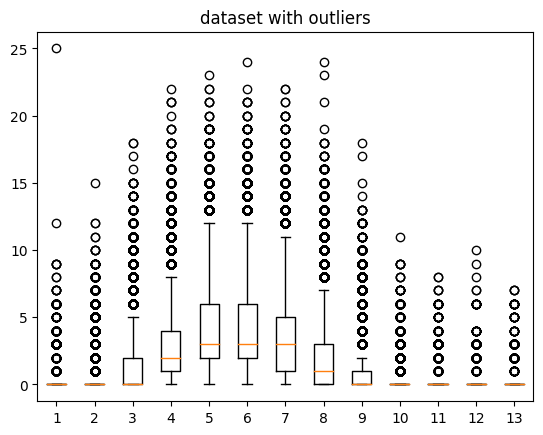

In [19]:
_ = plt.title("dataset with outliers")
_ = plt.boxplot(df.values, showfliers=True)

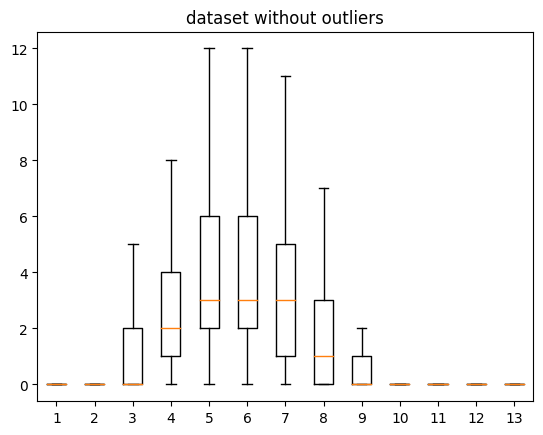

In [20]:
_ = plt.title("dataset without outliers")
_ = plt.boxplot(df.values, showfliers=False)

You should see all integers if you are using the `dataset 6-7-8` with 14th column quantized

In [21]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,1,3,3,5,3,3,0,0,0,0,0
1,0,0,0,4,9,6,7,3,0,0,0,0,0
2,0,0,2,3,4,3,1,0,0,0,0,0,0
3,0,0,1,1,2,2,0,0,0,0,0,0,0
4,0,0,5,6,5,5,2,0,0,0,0,0,0


In [22]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 25 , log2(max)= 5 , min= 0
X_test: max= 21 , log2(max)= 5 , min= 0


### Scale dataset

<p style="background-color:Yellow;"><b>Disabling scaling will simplify the hardware design</b></p>

In [23]:
scale = False

In [24]:
scaling = ''
if scale:
    scaling = 'scaling_'
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
else:
    scaling = 'noscaling_'

#### Visualize dataset post-scaling

In [25]:
pd.DataFrame(X_train).to_csv('csv/' + dataset + scaling + 'InputTrainSetScale.csv',index=False)
pd.DataFrame(X_test).to_csv('csv/' + dataset + scaling + 'InputTestSetScale.csv',index=False)

In [26]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,1,3,3,5,3,3,0,0,0,0,0
1,0,0,0,4,9,6,7,3,0,0,0,0,0
2,0,0,2,3,4,3,1,0,0,0,0,0,0
3,0,0,1,1,2,2,0,0,0,0,0,0,0
4,0,0,5,6,5,5,2,0,0,0,0,0,0


In [27]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 25 , log2(max)= 5 , min= 0
X_test: max= 21 , log2(max)= 5 , min= 0


### One-hot encoding

In [28]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

y_train_oh.to_csv("csv/" + dataset + "labelsTrainOH.csv",index=False)
y_test_oh.to_csv("csv/" + dataset + "labelsTestOH.csv",index=False)

In [29]:
display_side_by_side(pd.DataFrame(y_test[:5]), pd.DataFrame(y_test_oh[:5]), titles=['Prediction','One-hot encoding'])

Prediction 
 
 
 
 0 
 
 
 
 
 0 
 2 
 
 
 1 
 0 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 1 
 
 
 One-hot encoding 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 1 
 1 
 0 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 0 
 1 
 0

### Save .dat files

## Model (Keras)

Let's start with a Keras model that is more traditional and uses floating-point. Our goal is to eventually get a quantized model for QKeras and hls4ml that is _close enough_ to this initial model.

### Model definition

Define a few MLP models with different size and number of layers

In [30]:
models = {}

#### d128

This is our original model that we also use as a reference

In [31]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(128, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d128'] = {
    'prefix': dataset + padding + scaling + 'keras_d128',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d64

In [32]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(64, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d64'] = {
    'prefix': dataset + padding + scaling + 'keras_d64',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d60

In [33]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(60, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d60'] = {
    'prefix': dataset + padding + scaling + 'keras_d60',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d58

In [34]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(58, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d58'] = {
    'prefix': dataset + padding + scaling + 'keras_d58',
    'type'  : 'keras',
    'def'   : CreateModel}

### Model create and summary

Show the dictionary of models

In [35]:
print_dictionary(models)

d128
  prefix
    ds8l0_noscaling_keras_d128
  type
    keras
  def
    <function CreateModel at 0x7f54f548e280>
d64
  prefix
    ds8l0_noscaling_keras_d64
  type
    keras
  def
    <function CreateModel at 0x7f54f548e5e0>
d60
  prefix
    ds8l0_noscaling_keras_d60
  type
    keras
  def
    <function CreateModel at 0x7f54f548ea60>
d58
  prefix
    ds8l0_noscaling_keras_d58
  type
    keras
  def
    <function CreateModel at 0x7f54f548ed30>


<p style="background-color:Yellow;"><b>Choose a model for training and testing</b></p>


In [36]:
chosen_model = 'd58' # <<< PAY ATTENTION <<<

In [37]:
model_prefix = models[chosen_model]['prefix']
model_def = models[chosen_model]['def']
model_type = models[chosen_model]['type']

In [38]:
print(model_prefix)

ds8l0_noscaling_keras_d58


In [39]:
print(y_train)

[[0]
 [0]
 [0]
 ...
 [1]
 [2]
 [1]]


In [40]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 58)                812       
                                                                 
 batch_normalization (BatchN  (None, 58)               232       
 ormalization)                                                   
                                                                 
 relu1 (Activation)          (None, 58)                0         
                                                                 
 dense2 (Dense)              (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                             

### Model training

In [41]:
train_and_save = False # <<< PAY ATTENTION <<<

In [42]:
model_file = 'models/' + model_prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=512,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

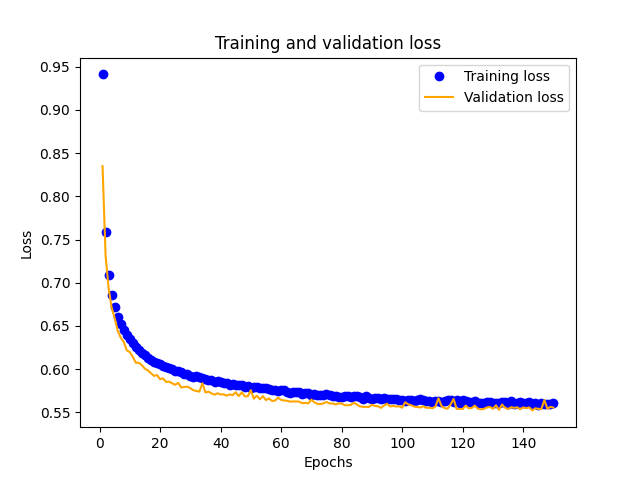

In [43]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + model_prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + model_prefix + 'loss.png')
    display(img)

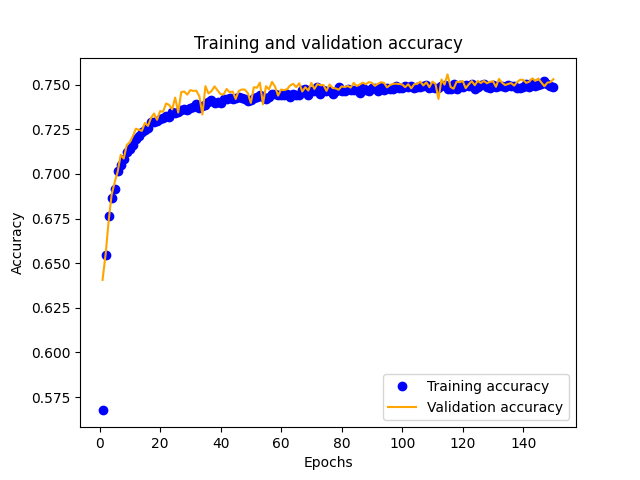

In [44]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + model_prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + model_prefix + 'accuracy.png')
    display(img)

In [45]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [46]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + model_prefix + "predictionsFiles.csv", header='predict', index=False)

In [47]:
pd.DataFrame(y_test).to_csv("csv/" + model_prefix + "true.csv", header='true', index=False)

In [48]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))

Test loss (Keras) d58: 0.5741040110588074
Test accuracy (Keras) d58: 0.7416539192199707


Confusion matrix:
[[4605  718  720]
 [ 807 1911   18]
 [ 605    3 1726]]


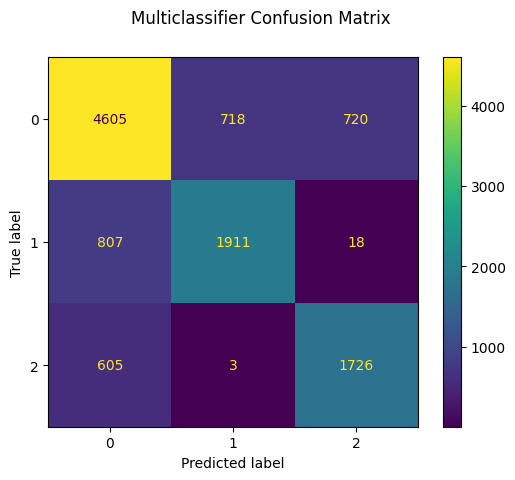

In [49]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + model_prefix + 'confusionMatrix.png')
plt.show()

Besides ML accuracy, we can evaluate the model with a metric that is closer to the physical application. We use _the number of tracks that are greater of 1.0 GeV and that are correctly classified as high pT_.

In [50]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = [0, 0, 0, 0]

In [51]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0, '<<<')
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0
- 0.5GeV correctly classified as high pT: 0
- 1.0GeV correctly classified as high pT: 0 <<<
- 2.0GeV correctly classified as high pT: 0
---


Summary of the results.

The model **id** is a label of the kind `dataset_scale_mltype_mlmodel`:
- `dataset` can be `ds7` (the original dataset) or `ds678` (the larger dataset with quantized 14th column)
- `scale` can be `scaling` (use standard scaler) or `noscaling` (don't scale)
- `mltype` can be `keras` (Keras), `qkeras` (QKeras), and `qkeras_foldbatchnorm` (QKeras + patch to fold batch normalization layer in the previous dense layer)
- `mlmodel` can be `d128`, `d64`, etc.

In [52]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,ds8l0_noscaling_keras_d58,0.5741,0.7417,0,0,0,0


Current and previous results

In [53]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0)

In [54]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,16/02/2023 19:27:38,ds8l0_noscaling_keras_d58,0.5686,0.7470,0,0,0,0
1,16/02/2023 19:28:06,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5898,0.7354,0,0,0,0
2,16/02/2023 19:28:16,ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d5...,0.0000,0.7357,0,0,0,0
3,16/02/2023 20:31:04,ds8l0_noscaling_keras_d58,0.5684,0.7462,0,0,0,0
4,16/02/2023 20:31:26,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.6017,0.7298,0,0,0,0
5,16/02/2023 20:36:57,ds8l0_noscaling_keras_d58,0.5741,0.7417,0,0,0,0
6,16/02/2023 20:37:57,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5920,0.7283,0,0,0,0


Average results so far

In [55]:
print_avg_results(results_filename)

,accuracy,nt_gev10,count
id,,,
ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.7357,0.0000,1
ds8l0_noscaling_keras_d58,0.7450,0.0000,3
ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.7312,0.0000,3


In [56]:
id_ordering = get_model_ids(lrange=[0],
                            srange=['noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )

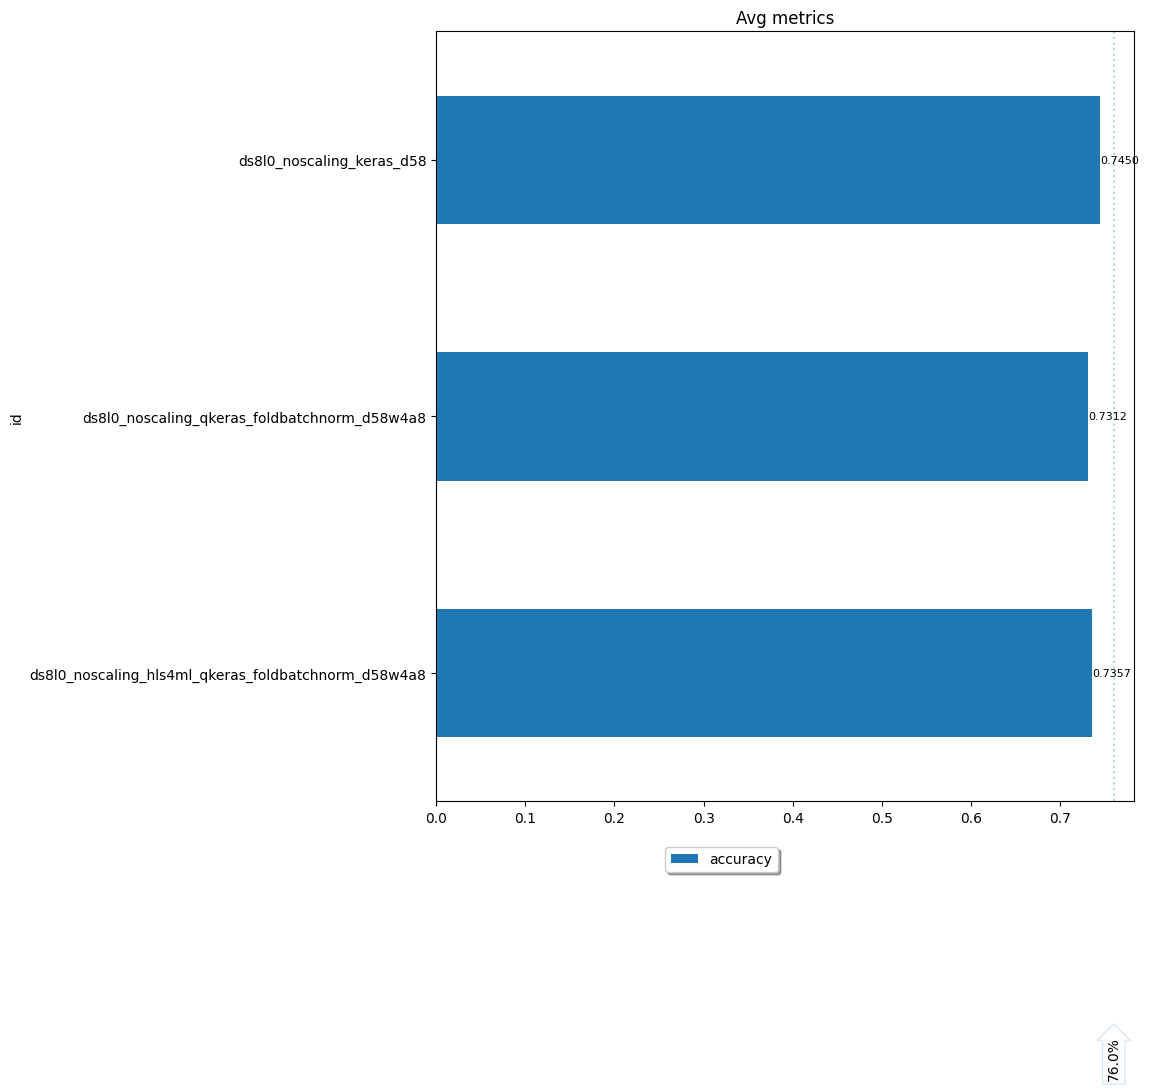

In [57]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

- Dataset:
  - `ds7` is the `dataset 7`
  - `ds7q` is `dataset 7` where we also quantized 14th column on 12 bins
  - `ds8` is `dataset 8`
  - `ds8q` is `dataset 8` where we also quantized 14th column on 12 bins
  - `ds678q` is `dataset 6-7-8` where we also quantized 14th column on 12 bins
- All of the dataset are non scaled (`noscaling`)
- Model:
  - `keras` use Keras
  - `qkeras` use QKeras (quantized model)
- If it says `foldbatchnorm` then we folded the Batch Normalization layer in the previous Dense layer

## Model (QKeras)

Mostly the same as the previous section, but now we are usin QKeras

### Model definition

In [58]:
qmodels = {}

#### qkeras-foldbatchnorm-d128w5a10

In [59]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d128w4a8

In [60]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w5a10

In [61]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w4a8

In [62]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w5a10

In [63]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w4a8

In [64]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w5a10

In [65]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(58,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w4a8

In [66]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    
    x = QDenseBatchnorm(58,
       kernel_quantizer=quantized_bits(4,0,alpha=1),
       bias_quantizer=quantized_bits(4,0,alpha=1),
       name="dense1")(x)
    # x = QDense(58,
    #     kernel_quantizer=quantized_bits(4,0,alpha=1),
    #     bias_quantizer=quantized_bits(4,0,alpha=1),
    #     name="dense1")(x)
    # x = keras.layers.BatchNormalization()(x)
    
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

### Model create and summary

In [67]:
print_dictionary(qmodels)

d128w5a10
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d128w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e04813a0>
d128w4a8
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d128w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e0481670>
d64w5a10
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d64w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e0481a60>
d64w4a8
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d64w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e0481dc0>
d60w5a10
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d60w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e04883a0>
d60w4a8
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d60w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x7f54e04884c0>
d58w5a10
  prefix
    ds8l0_noscaling_qkeras_foldbatchnorm_d58w5a10
  type
    qkeras_fold

<p style="background-color:Yellow;"><b>Choose a QKeras model for training and testing. Pay attention to the previously created model in Keras.</b></p>

In [68]:
print('Keras model:', chosen_model)

Keras model: d58


In [69]:
chosen_qmodel = 'd58w4a8'  # <<< PAY ATTENTION <<<

In [70]:
qmodel_prefix = qmodels[chosen_qmodel]['prefix']
qmodel_def = qmodels[chosen_qmodel]['def']
qmodel_type = qmodels[chosen_qmodel]['type']

In [71]:
model = qmodel_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 13)]              0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 58)                1045      
                                                                 
 relu1 (QActivation)         (None, 58)                0         
                                                                 
 dense2 (QDense)             (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                                 
Total params: 1,222
Trainable params: 1,105
Non-trainable params: 117
_________________________________________________________________


### Model training

In [72]:
train_and_save = False # <<< PAY ATTENTION <<<

In [73]:
from qkeras.utils import model_save_quantized_weights

model_file = 'models/' + qmodel_prefix + 'model.h5'
model_q_weights_file = 'models/' + qmodel_prefix + 'model_q_weights.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model_save_quantized_weights(model, model_q_weights_file)
    model.save(model_file)
    print('Save:', model_file)
    print('Save:', model_q_weights_file)

co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

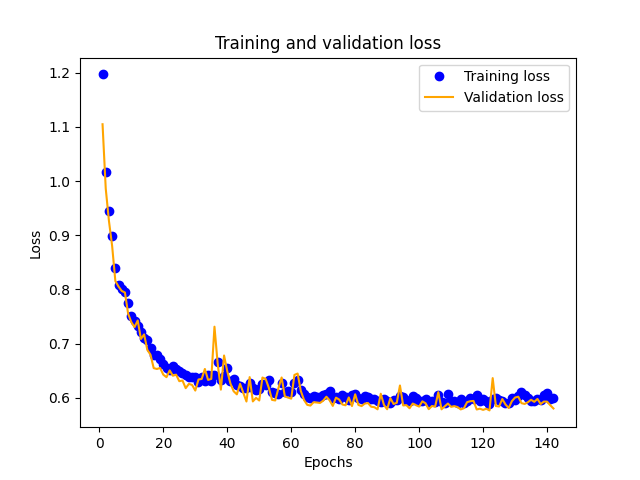

In [74]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + qmodel_prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + qmodel_prefix + 'loss.png')
    display(img)

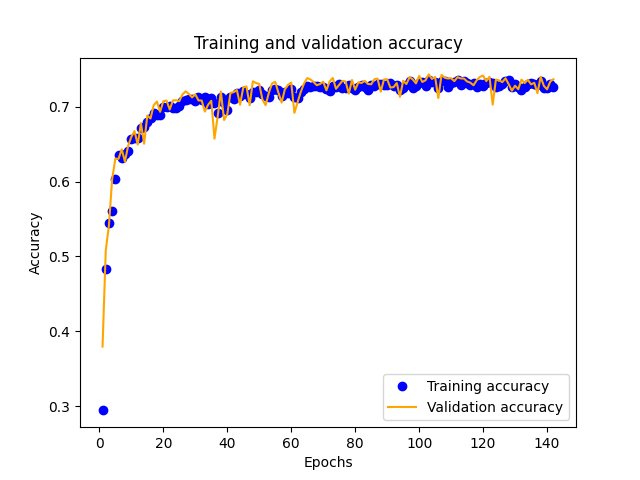

In [75]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + qmodel_prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + qmodel_prefix + 'accuracy.png')
    display(img)

In [76]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [77]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + qmodel_prefix + "predictionsFiles.csv", header='predict', index=False)

In [78]:
pd.DataFrame(y_test).to_csv("csv/" + qmodel_prefix + "true.csv", header='true', index=False)

In [79]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (QKeras) {}: {}".format(chosen_model, score[1]))

Test loss (QKeras) d58: 0.5919830799102783
Test accuracy (QKeras) d58: 0.7283361554145813


Confusion matrix:
[[4930  535  578]
 [1048 1675   13]
 [ 840    5 1489]]


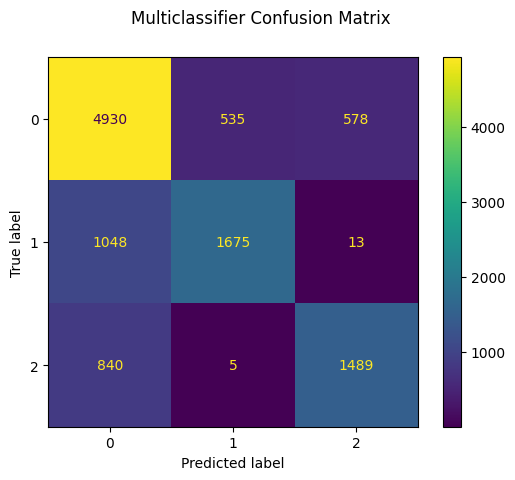

In [80]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + qmodel_prefix + 'confusionMatrix.png')
plt.show()

In [81]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = [0, 0, 0, 0]

In [82]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0
- 0.5GeV correctly classified as high pT: 0
- 1.0GeV correctly classified as high pT: 0
- 2.0GeV correctly classified as high pT: 0
---


In [83]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5920,0.7283,0,0,0,0


In [84]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0)

In [85]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,16/02/2023 19:27:38,ds8l0_noscaling_keras_d58,0.5686,0.7470,0,0,0,0
1,16/02/2023 19:28:06,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5898,0.7354,0,0,0,0
2,16/02/2023 19:28:16,ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d5...,0.0000,0.7357,0,0,0,0
3,16/02/2023 20:31:04,ds8l0_noscaling_keras_d58,0.5684,0.7462,0,0,0,0
4,16/02/2023 20:31:26,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.6017,0.7298,0,0,0,0
5,16/02/2023 20:36:57,ds8l0_noscaling_keras_d58,0.5741,0.7417,0,0,0,0
6,16/02/2023 20:37:57,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5920,0.7283,0,0,0,0


In [86]:
print_avg_results(results_filename)

,accuracy,nt_gev10,count
id,,,
ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.7357,0.0000,1
ds8l0_noscaling_keras_d58,0.7450,0.0000,3
ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.7312,0.0000,3


In [87]:
id_ordering = get_model_ids(lrange=[0],
                            srange=['noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )

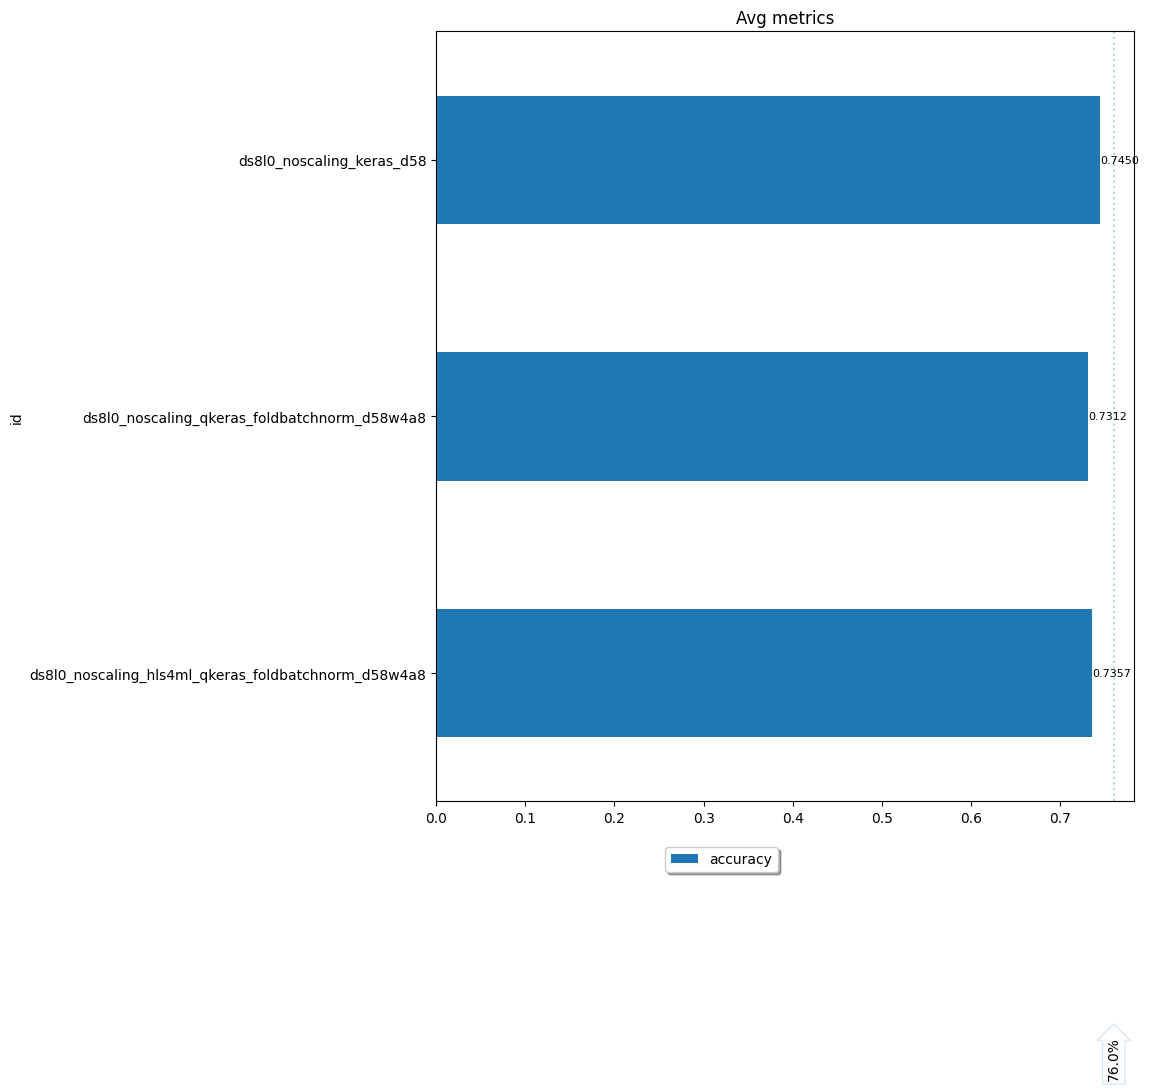

In [88]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

## Hardware translation

### hls4ml configuration

#### Setup

In [89]:
import hls4ml
import plotting

hmodel_prefix = dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel

/home/giuseppe/research/projects/fnal/CMS_PIX_28/hls4ml/hls4ml_catapult/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [90]:
print('------------------------------------')
print(hmodel_prefix)
print('------------------------------------')

------------------------------------
ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8
------------------------------------


In [91]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.1.0.dev1479+gaef46bd.d20230217


In [92]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


In [93]:
input_size = 6

#### d**w5a10

#### d**w4a8

In [131]:
# hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
    layers=['Activation'],
    rounding_mode='AP_RND_CONV',
    saturation_mode='AP_SAT')



hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

#hconfig['Model']['Precision'] = 'ap_fixed<16,8>'

# Input
hconfig['LayerName']['input1']['Precision']['result'] = 'ap_ufixed<' + str(input_size) + ',' + str(input_size) + '>'

# Dense
#hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<8,5>'
#hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<8,5>'
#hconfig['LayerName']['dense1']['Precision']['default'] = 'ap_fixed<8,5>'

# ReLU
#hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<8,0>'

# Dense
#hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'
#hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'

# SoftMax
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'

#hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'

# Required for the folding of BatchNormalization
hconfig['SkipOptimizers'] = ['propagate_dense_precision']

for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True
    
hconfig['LayerName']['dense1_linear']['Trace'] = True
hconfig['LayerName']['dense2_linear']['Trace'] = True

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 13]], output shape: [None, 13]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 13]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]


#### Convert

In [132]:
plotting.print_dict(hconfig)

Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input1
    Trace:           True
    Precision
      result:        ap_ufixed<6,6>
  dense1
    Trace:           True
    Precision
      result:        fixed<16,6>
      weight:        fixed<4,1>
      bias:          fixed<4,1>
  dense1_linear
    Trace:           True
    Precision
      result:        fixed<16,6>
  relu1
    Trace:           True
    Precision
      result:        ufixed<8,0>
  dense2
    Trace:           True
    Precision
      result:        fixed<16,6>
      weight:        fixed<4,1>
      bias:          fixed<4,1>
  dense2_linear
    Trace:           True
    Precision
      result:        fixed<16,6>
  linear
    Trace:           True
    Precision
      result:        fixed<16,6>
SkipOptimizers:      ['propagate_dense_precision']


In [135]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=hmodel_prefix + '_' + str(run_id) + '_catapult_prj',
                                                    backend='Catapult',
                                                    part='XC7A100T')

Exception: Unknown backend: Catapult

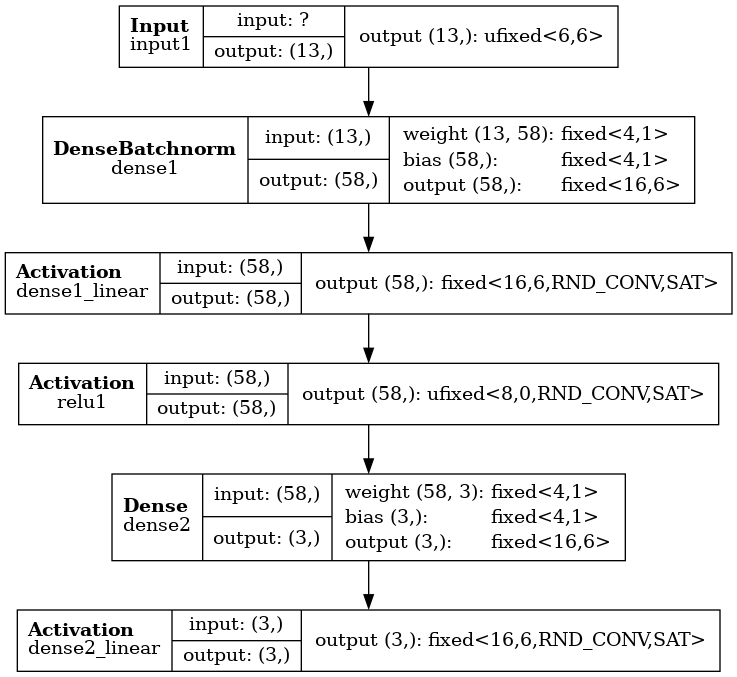

In [118]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

### Bit-accurate simulation

In [119]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test.astype(float)))

Recompiling myproject with tracing
Writing HLS project
Done


In [120]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

Processing input1 in Keras model...
Processing dense1 in Keras model...
Processing relu1 in Keras model...
Processing dense2 in Keras model...
Processing linear in Keras model...
Done taking outputs for Keras model.


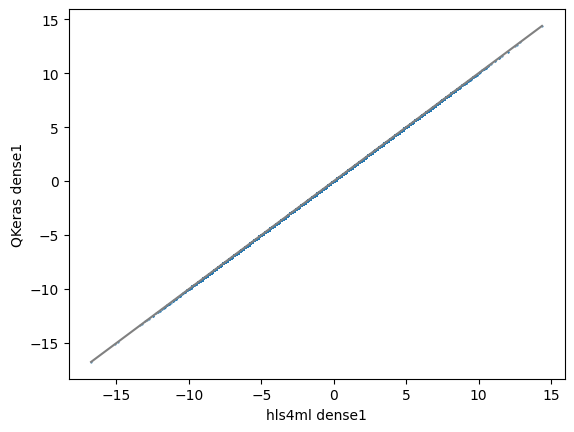

<Figure size 640x480 with 0 Axes>

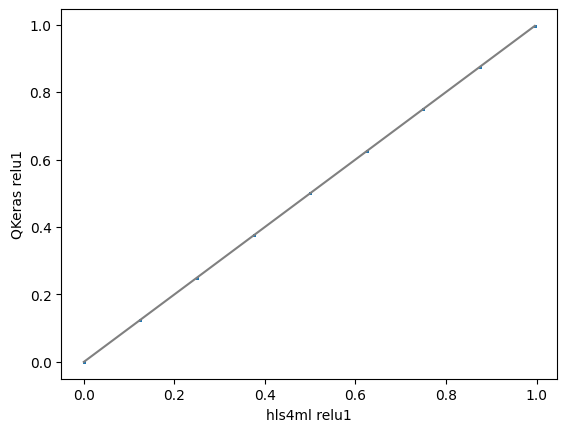

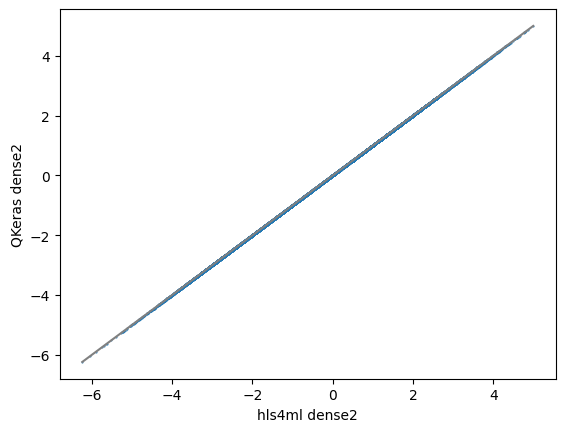

<Figure size 640x480 with 0 Axes>

In [121]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    if 'dense1_linear' in layer:
        continue
    if 'dense2_linear' in layer:
        continue
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join(hmodel_prefix + '_' + str(run_id) + '_vivado_prj', 'profiling_{}.png'.format(layer)), dpi=300)

### Model evaluation

In [122]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    part='XC7A100T')

hmodel.compile()

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 13]], output shape: [None, 13]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 13]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Writing HLS project
Done


In [123]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test.astype(float)))
np.savetxt('tb_output_predictions_hw.dat', hpreds, fmt='%f')

In [124]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

-----------------------------------
QKeras accuracy: 72.8336%
hls4ml accuracy: 72.8156%
-----------------------------------


In [104]:
hls4ml_accuracy = accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))

In [105]:
for i in range(5):
    print('X[{}], {}'.format(i, X_test[i]))
    print('golden y[{}]'.format(i), y_test[i])
    print('onehot y[{}]'.format(i), y_test_oh.values[i])
    print('QKeras y[{}]'.format(i), preds[i])
    print('hls4ml y[{}]'.format(i), hpreds[i])
    print()

X[0], [0 0 1 3 3 5 3 3 0 0 0 0 0]
golden y[0] [2]
onehot y[0] [0 0 1]
QKeras y[0] [ 2.0112305 -1.9179688  1.1396484]
hls4ml y[0] [ 2.00976562 -1.91992188  1.13867188]

X[1], [0 0 0 4 9 6 7 3 0 0 0 0 0]
golden y[1] [0]
onehot y[1] [1 0 0]
QKeras y[1] [ 1.2163086   0.12060547 -1.5883789 ]
hls4ml y[1] [ 1.21191406  0.11523438 -1.59277344]

X[2], [0 0 2 3 4 3 1 0 0 0 0 0 0]
golden y[2] [1]
onehot y[2] [0 1 0]
QKeras y[2] [ 1.5878906  -0.46240234 -2.3432617 ]
hls4ml y[2] [ 1.58691406 -0.46386719 -2.34472656]

X[3], [0 0 1 1 2 2 0 0 0 0 0 0 0]
golden y[3] [0]
onehot y[3] [1 0 0]
QKeras y[3] [ 0.85595703  0.30419922 -1.8608398 ]
hls4ml y[3] [ 0.85546875  0.30371094 -1.86230469]

X[4], [0 0 5 6 5 5 2 0 0 0 0 0 0]
golden y[4] [1]
onehot y[4] [0 1 0]
QKeras y[4] [ 1.3208008  -0.11962891 -1.7636719 ]
hls4ml y[4] [ 1.31835938 -0.12304688 -1.76855469]



In [106]:
display_side_by_side(pd.DataFrame(X_test[:5]), titles=['Scaled input'])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,1,3,3,5,3,3,0,0,0,0,0
1,0,0,0,4,9,6,7,3,0,0,0,0,0
2,0,0,2,3,4,3,1,0,0,0,0,0,0
3,0,0,1,1,2,2,0,0,0,0,0,0,0
4,0,0,5,6,5,5,2,0,0,0,0,0,0


In [107]:
display_side_by_side(pd.DataFrame(y_test[:5]),
                     pd.DataFrame(y_test_oh[:5]),
                     pd.DataFrame(preds[:5]),
                     pd.DataFrame(hpreds[:5]),
                     titles=['Expected prediction','Expected prediction (one-hot enc.)', 'QKeras prediction', 'hls4ml prediction'])

Expected prediction 
 
 
 
 0 
 
 
 
 
 0 
 2 
 
 
 1 
 0 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 1 
 
 
 Expected prediction (one-hot enc.) 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 1 
 1 
 0 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 0 
 1 
 0 
 
 
 QKeras prediction 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 2.011230 
 -1.917969 
 1.139648 
 
 
 1 
 1.216309 
 0.120605 
 -1.588379 
 
 
 2 
 1.587891 
 -0.462402 
 -2.343262 
 
 
 3 
 0.855957 
 0.304199 
 -1.860840 
 
 
 4 
 1.320801 
 -0.119629 
 -1.763672 
 
 
 hls4ml prediction 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 2.009766 
 -1.919922 
 1.138672 
 
 
 1 
 1.211914 
 0.115234 
 -1.592773 
 
 
 2 
 1.586914 
 -0.463867 
 -2.344727 
 
 
 3 
 0.855469 
 0.303711 
 -1.862305 
 
 
 4 
 1.318359 
 -0.123047 
 -1.768555

In [108]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = [0, 0, 0, 0]

In [109]:
print(hmodel_prefix)

ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8


In [110]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d5...,0,0.7282,0,0,0,0


In [111]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0)

In [112]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,16/02/2023 19:27:38,ds8l0_noscaling_keras_d58,0.5686,0.7470,0,0,0,0
1,16/02/2023 19:28:06,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5898,0.7354,0,0,0,0
2,16/02/2023 19:28:16,ds8l0_noscaling_hls4ml_qkeras_foldbatchnorm_d5...,0.0000,0.7357,0,0,0,0
3,16/02/2023 20:31:04,ds8l0_noscaling_keras_d58,0.5684,0.7462,0,0,0,0
4,16/02/2023 20:31:26,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.6017,0.7298,0,0,0,0
5,16/02/2023 20:36:57,ds8l0_noscaling_keras_d58,0.5741,0.7417,0,0,0,0
6,16/02/2023 20:37:57,ds8l0_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5920,0.7283,0,0,0,0


In [113]:
id_ordering = get_model_ids(lrange=[0],
                            srange=['noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )

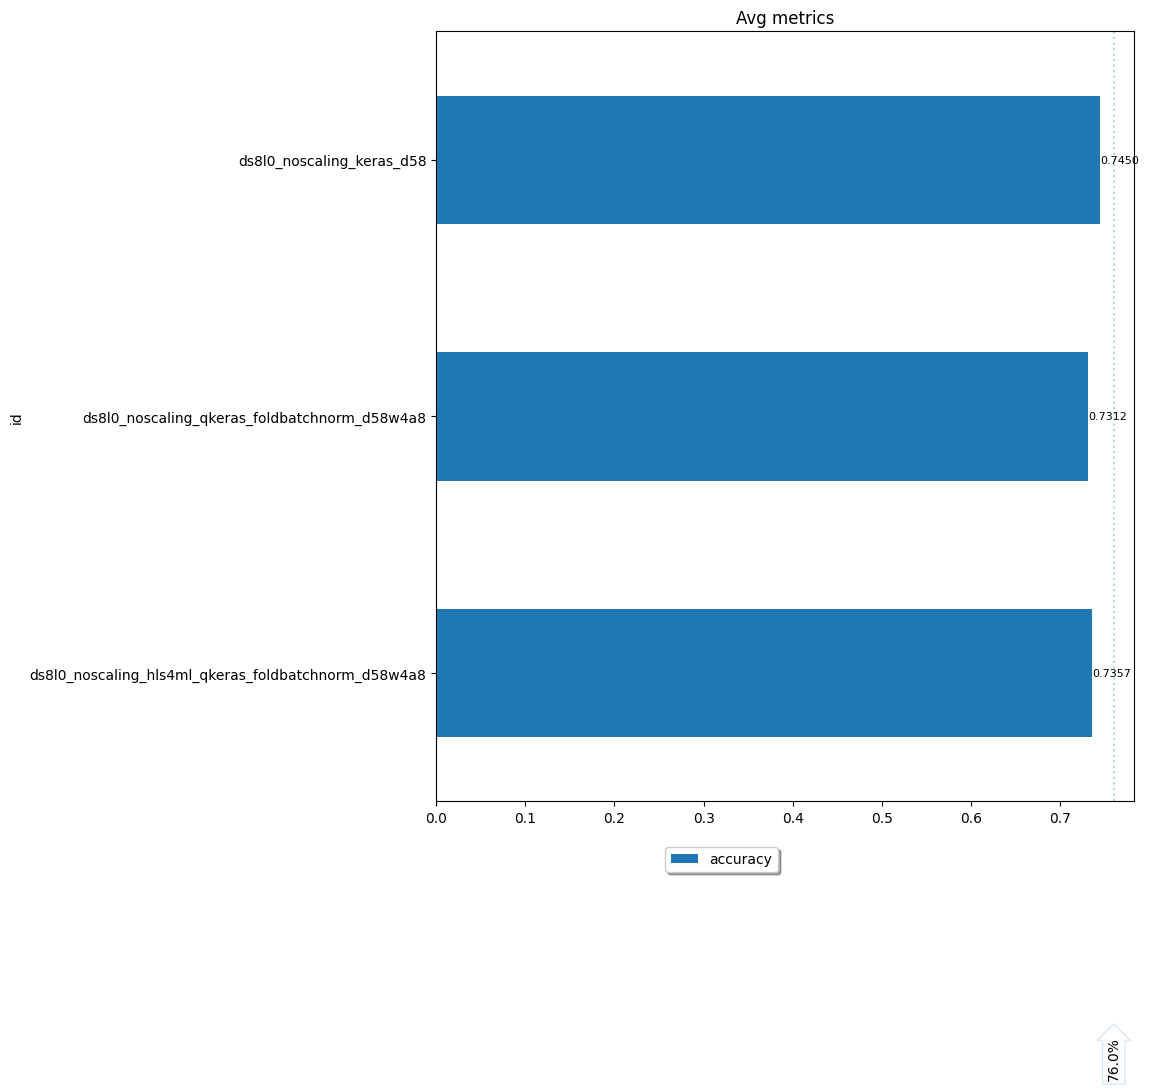

In [114]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

### Synthesis